# DATA620: Project 2

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

In [143]:
import pandas as pd
import numpy as np
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import powerlaw

## Project Objectives

1. Identify a large 2-node network dataset. (Meet the criteria tat it consists of ties between and not within two (or more) distinct groups
2. Reduce the size of the network using a method such as the island method
3. What can you infer about each of the distinct groups?

<br>

## Research Summary

This dataset we selected was developed to support network analysis research of an online communities. The findings were reported in a paper by Pietro Panzarasa and Tore Opsahl titled "Patterns and Dynamics of Users’ Behavior and Interaction". The research draws on longitudinal network data from an online community to examine patterns of users’ behavior and social interaction, to infer the dynamics of system usage.

The research includes a note of caution regarding the relationship assumptions that underpin the analysis. The dataset assumes that one message is sufficient to create a relationship. It is acknowledged that this is a week notion of a social relationship. However this formulation enables the inclusion of all users in the analysis but might overestimate the density of the relationship structure in the graph.

The authors also discuss their limited ability to observe previously established offline relationships. The evolution of the network is a combination of previous offline relationships and new relationships that are developed on the platform. This analysis will likely be impacted / capture offline relationships.

And finally the lack of message content hampers the ability to analyze and further investigate the genuine nature of the relationships identified. It would be beneficial to interrogate the substance of the messages and use that information to assess the strength of relationships.

## Data Source

The dataset that we decided to use for this project is a Facebook-like Forum Network that was obtained from https://toreopsahl.com/datasets/#online_forum_network. This network does not focus on the messages exchanged between user, rather the focus is between users and topics that they partake in. The network can be weighted where the weight is based on the number of messages or characters a user has posted on a particular topic. We elected to use a static two mode network with an edge weight that is based on messages. The two-mode network contains 899 users and 522 topics.

In [144]:
# Read in network data using num of messages for weight

# 2 mode: users and topics
weighted_2mode = pd.read_csv('http://opsahl.co.uk/tnet/datasets/OF_two-mode_weightedmsg.txt',
                            sep = ' ',
                            header = None)

#set the colunmns
weighted_2mode.columns = ["User", "Topic", "Weight"]

# update the user and topic to be unique
weighted_2mode['User'] = 'U' + weighted_2mode['User'].astype(str)
weighted_2mode['Topic'] = 'T' + weighted_2mode['Topic'].astype(str)

# metrics
u_df = weighted_2mode.groupby('User')
u_df = u_df[['User']].agg(np.size)

t_df = weighted_2mode.groupby('Topic')
t_df = t_df[['Topic']].agg(np.size)

print('The dataset has',weighted_2mode.shape[0], 'rows and', weighted_2mode.shape[1], 'columns')
print('There are',u_df.shape[0] ,'unique users in the dataset and',t_df.shape[0],'unique topics')

The dataset has 7089 rows and 3 columns
There are 899 unique users in the dataset and 522 unique topics


First step in the analysis of the data is to review the distribution of the edge weights. The Box plot and the histogram indicates discrepancy in topic popularity. Most topics have fairly low engagement below 10 messages from the network. However there are a few topics that are incredibly popular with over 100 messages associated with those topics.

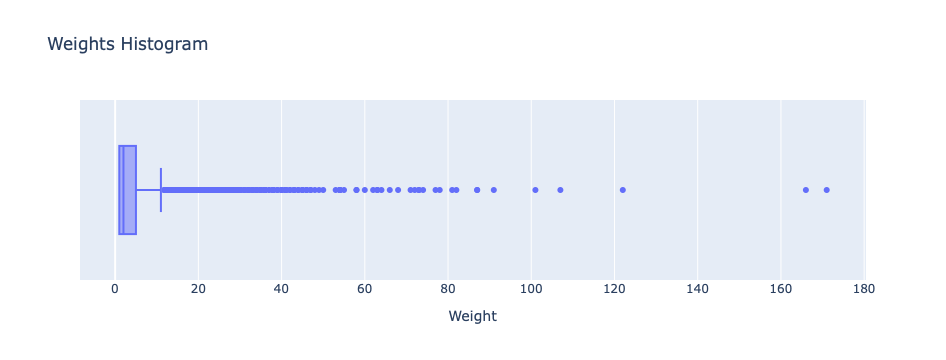

In [145]:
fig = px.box(weighted_2mode, x="Weight", hover_data=weighted_2mode.columns,
                  title="Weights Histogram")
fig.show()

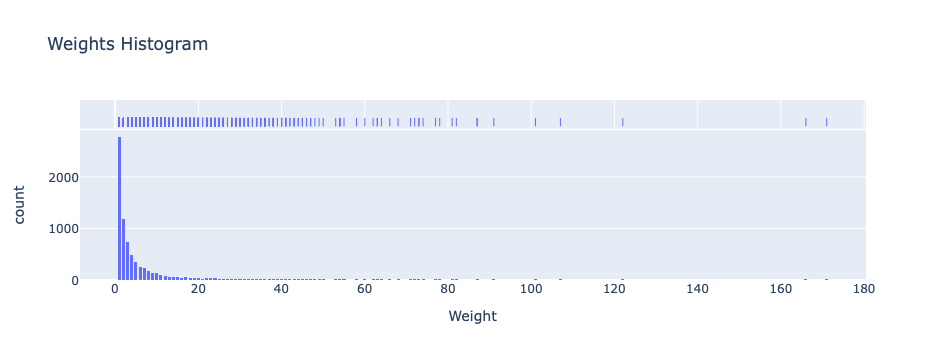

In [146]:
fig = px.histogram(weighted_2mode, x="Weight", marginal="rug",nbins=600, hover_data=weighted_2mode.columns,
                  title="Weights Histogram")
fig.show()

## Load Bipartite Graph

Using the data frame that was previously loaded we will create a Bipartite graph with both Topic and User nodes. The weights for the edges will capture the number of messages posted on a topic by the connected users.

In [147]:
# create the graph with the two node types
B = nx.Graph()
B.add_nodes_from(weighted_2mode['Topic'], bipartite=0)
B.add_nodes_from(weighted_2mode['User'], bipartite=1)

# add the weights
tuples = [tuple(x) for x in weighted_2mode.to_numpy()]
B.add_weighted_edges_from(tuples, weight='weight')

# test to see if the graph is connected
print('We confirm that connected status of the graph. Graph connected status:',nx.is_connected(B))

# verify that a bipartite graph was created
print('We also confirmed that the the graph is a bipartite graph. Graph bipartite status',nx.is_bipartite(B))

# create node lists for each node type
topic_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
user_nodes = set(B) - topic_nodes

We confirm that connected status of the graph. Graph connected status: False
We also confirmed that the the graph is a bipartite graph. Graph bipartite status True


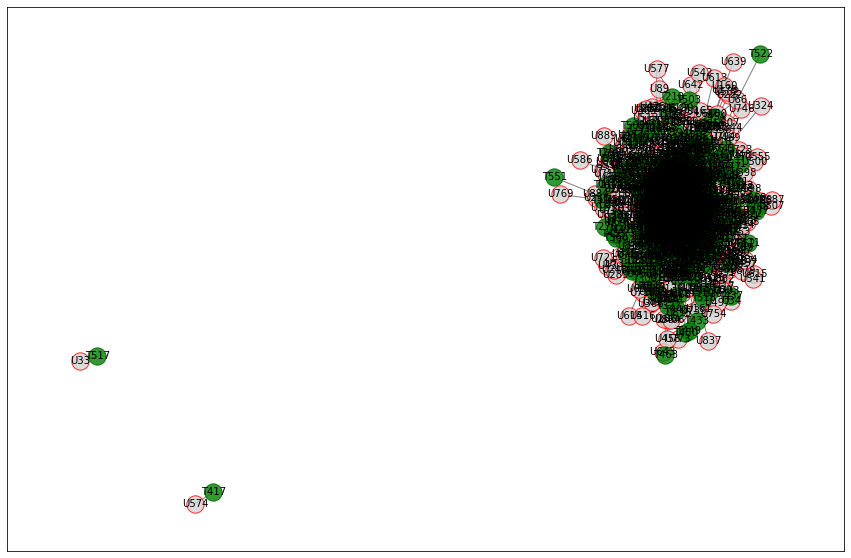

In [148]:
plt.figure(figsize = (15,10))
pos = nx.spring_layout(B)



nx.draw_networkx_nodes(B,pos,
                       nodelist=user_nodes,
                       node_color='lightgray',
                       edgecolors='red',
                       alpha=0.8)
topic = weighted_2mode['Topic']
nx.draw_networkx_nodes(B,pos,
                       nodelist=topic_nodes,
                       node_color='green',
                       edgecolors='darkgreen',
                       alpha=0.8)

nx.draw_networkx_edges(B, pos,
                       edge_color='gray',
                      )


dump = nx.draw_networkx_labels(B, pos, font_size=10)

The resulting graph is difficult to read however we can identify 1 large set of connected nodes and several smaller connected nodes. These Topic and User clusters depict issolated relationships between Users and Topics.

<br>

## Analyze a Filtered Graph
To isolate some of the more frequently engaged Users and Topics we used the edge weights to filter out every edge with less than 40 messages.

In [149]:
reduced_df = weighted_2mode[weighted_2mode['Weight'] > 60]

u_df = reduced_df.groupby('User')
u_df = u_df[['User']].agg(np.size)
#u_df.shape

t_df = reduced_df.groupby('Topic')
t_df = t_df[['Topic']].agg(np.size)
#t_df.shape

print('This results in a much smaller graph with',u_df.shape[0],'users and',t_df.shape[0],'topics.')

This results in a much smaller graph with 17 users and 11 topics.


<br>

Using the reduced dataframe to build a smaller bipartite graph. The resulting graph highlights that even in this reduced set there are still some very popular topics and prolific authors. 

In [150]:
R = nx.Graph()
R.add_nodes_from(reduced_df['Topic'], bipartite=0)
R.add_nodes_from(reduced_df['User'], bipartite=1)

tuples = [tuple(x) for x in reduced_df.to_numpy()]
R.add_weighted_edges_from(tuples, weight='weight')

topic_nodes_r = {n for n, d in R.nodes(data=True) if d["bipartite"] == 0}
user_nodes_r = set(R) - topic_nodes_r

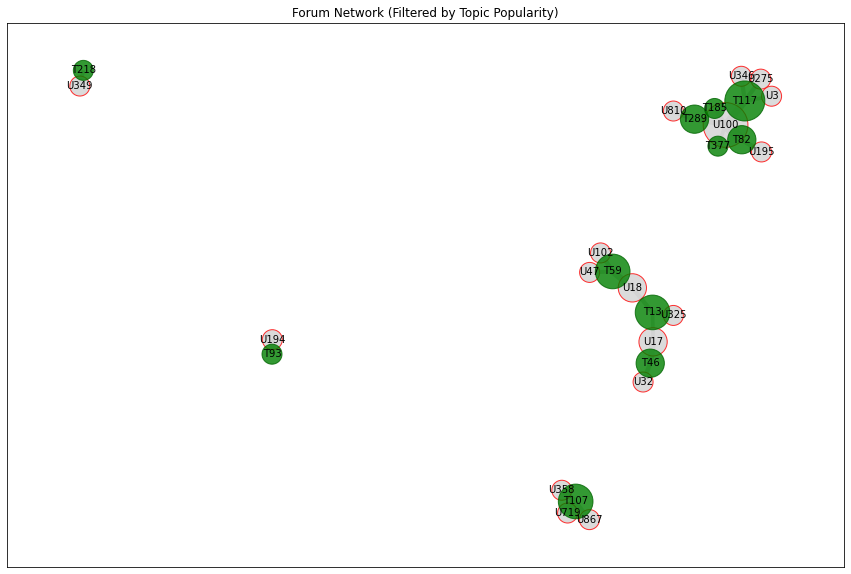

In [151]:
plt.figure(figsize = (15,10))
plt.title('Forum Network (Filtered by Topic Popularity)')

pos = nx.spring_layout(R)

edge_labels = nx.get_edge_attributes(R, 'weight')
edge_w = np.array(list(edge_labels.values())) * 0.06



userDegree_r = nx.degree(R, user_nodes_r) 
topicDegree_r = nx.degree(R, topic_nodes_r) 


nx.draw_networkx_nodes(R,pos,
                       nodelist=user_nodes_r,
                       node_color='lightgray',
                       node_size=[v * 400 for v in dict(userDegree_r).values()],
                       edgecolors='red',
                       
                       alpha=0.8)

nx.draw_networkx_nodes(R,pos,
                       nodelist=topic_nodes_r,
                       node_color='green',
                       node_size=[v * 400 for v in dict(topicDegree_r).values()],
                       edgecolors='darkgreen',
                       alpha=0.8)

nx.draw_networkx_edges(R, pos,
                       edge_color='lightgray',
                       width=edge_w, 
                       #edge_color=edge_w,
                       edge_cmap=mpl.cm.Greys
                      )

dump = nx.draw_networkx_labels(R, pos, font_size=10)
plt.show()

The resulting graph highlights even in this reduced set there are still some very popular topics and prolific users.

<br>

## Scale-Free Network
The research paper concludes that this is an example of a scale free network. In researching the prevalence of scale-free networks there seems to be some discussion and disagreement about the widespread existence of scale-free networks. Common types of scale-free networks include social networks and computer networks. Some of the characteristics of scale free network include:
* degree follows the powers law - distribution of a scale free network follow the powers law however the degree distribution may deviate as the network become larger.
* preferential attachments - new nodes prefer to connect with nods that already have high numbers of links.
* prevalence of hubs - relative commonness of vertices with a degree that greatly exceeds the average. these high degree nodes are often called hubs
* network resilience - little impact to the constructiveness of the network when large fractions of vertices are removed

<br>

In assessing if the Forum Network in question is a scale free network we looked at:
* degree distribution - reviewed the degree distribution across both node types
* powers law - used a graph of powers law to assess the conformity of the network to powers law


<br>

### Degree Distribution
The distribution of degree measurements for both User and Topic nodes suggest that the Forum Network could be scale free. We will use the box plot and standard populations measures of dismemberment to evaluate the degree measures of centrality of each node type. 

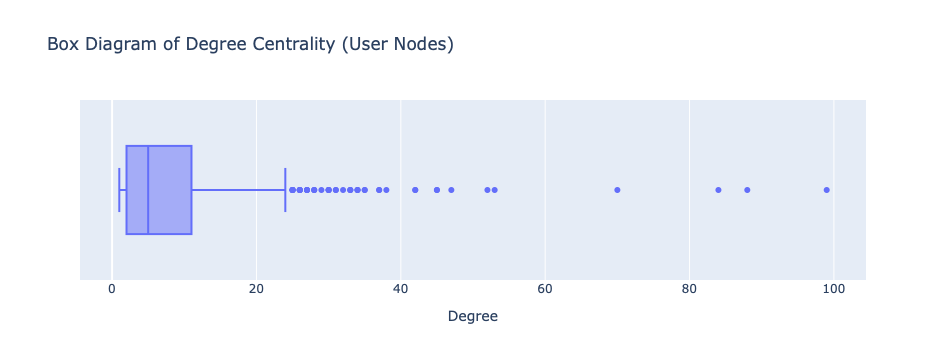

In [152]:
userDegree = nx.degree(B, user_nodes) 
user_degree_df = pd.DataFrame(userDegree, columns=['User','Degree'])

fig = px.box(user_degree_df, x='Degree', title="Box Diagram of Degree Centrality (User Nodes)")
fig.show()

In [153]:
user_degree_df.describe()

,Degree
count,899.000000
mean,7.885428
std,9.598928
min,1.000000
25%,2.000000
50%,5.000000
75%,11.000000
max,99.000000


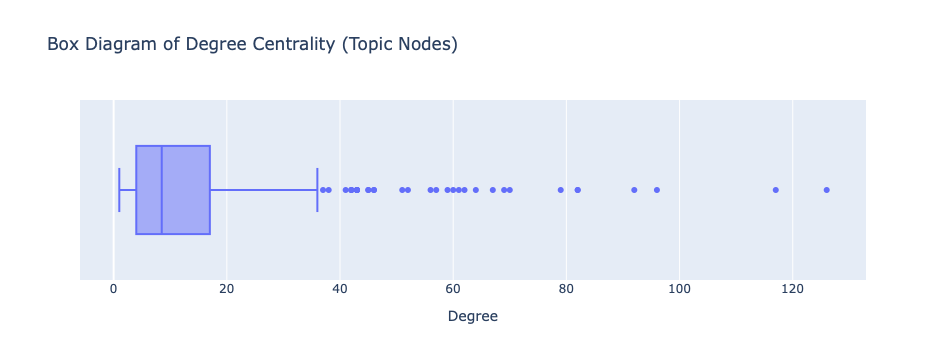

In [154]:
topicDegree = nx.degree(B, topic_nodes) 
topic_degree_df = pd.DataFrame(topicDegree, columns=['User','Degree'])
fig = px.box(topic_degree_df, x='Degree', title="Box Diagram of Degree Centrality (Topic Nodes)")
fig.show()

In [155]:
topic_degree_df.describe()

,Degree
count,522.000000
mean,13.580460
std,15.729669
min,1.000000
25%,4.000000
50%,8.500000
75%,17.000000
max,126.000000


The distribution of degree centrality measures for both node supports that assertion that the Forum Network is a scale free network. The mean measure of degree centrality is 7.9 and 13.6 for Users and Topics respectively. In both instances the 75% percentile is above the mean indicating that there is a high probability of encountering a node that has a degree of centrality measure that is well above the mean. This can also be observed from the box plots. 

<br>

### Powers Law
Review the relationship between degree measure of centrality and the powers law. If distribution conforms to the powers law we should observe a proportional change in the probablity density function.  This is a functional relationship between two quantities, where a relative change in one quantity results in a proportional relative change in the other quantity, independent of the initial size of those quantities: one quantity varies as a power of another.

In [156]:
# calculate the degree distribution for the graph and fit it to the graph
degree_sequence = sorted([d for n, d in userDegree], reverse=True) # used for degree distribution and powerlaw test
fit = powerlaw.Fit(degree_sequence) 
R, p = fit.distribution_compare('power_law', 'lognormal',normalized_ratio=True)

Calculating best minimal value for power law fit


/Users/davidsimbandumwe/opt/anaconda3/envs/DATA620/lib/python3.8/site-packages/powerlaw.py:1615: RuntimeWarning:

invalid value encountered in true_divide

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [157]:
#Calculating best minimal value for power law fit'
print('alpha:',round(fit.power_law.alpha,4))
print('sigma:',round(fit.power_law.sigma,4))
print('xmin:',round(fit.power_law.xmin,4))
print('R:',round(R,4))
print('p:',round(p,4))

alpha: 4.1508
sigma: 0.4548
xmin: 25.0
R: -2.0612
p: 0.0393


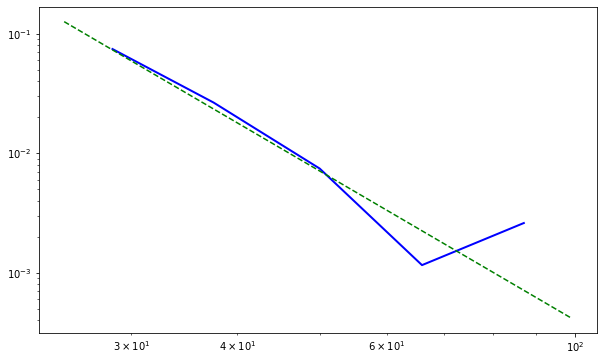

In [158]:
plt.figure(figsize=(10, 6))
fig2 = fit.plot_pdf(color='b',linewidth=2)
dump = fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)

/Users/davidsimbandumwe/opt/anaconda3/envs/DATA620/lib/python3.8/site-packages/powerlaw.py:1615: RuntimeWarning:

invalid value encountered in true_divide

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


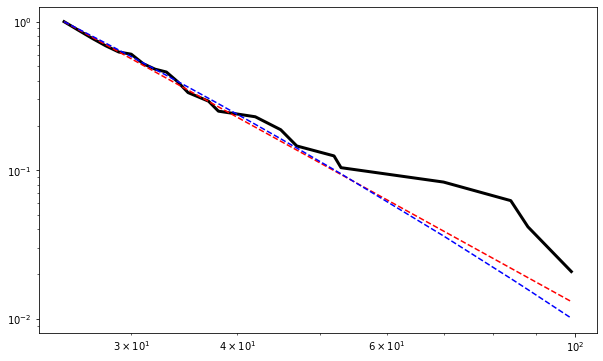

In [159]:
plt.figure(figsize=(10, 6))
fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
fig4 = fit.plot_ccdf(linewidth=3, color='black')
fit.power_law.plot_ccdf(ax=fig4, color='r', linestyle='--') #powerlaw
fit.lognormal.plot_ccdf(ax=fig4, color='g', linestyle='--') #lognormal
dump = fit.stretched_exponential.plot_ccdf(ax=fig4, color='b', linestyle='--') #stretched_exponential

From these calculations that results seem incluslive about if this conforms to the powers law.



<br>

## One Mode Projection - Users
Graph Projection is used to analyze the centrality measures for the Forum Network network. We will use degree, closeness, betweenes and eigenvectors centrality measures to assess the relative importance of each User node to the network

* First, we will project the graph onto the User node
* Visualize the full graph
* Calculate degree, closeness, betweenness and eigenvectors centrality for the graph
* Identify the nodes with higher centrality measures

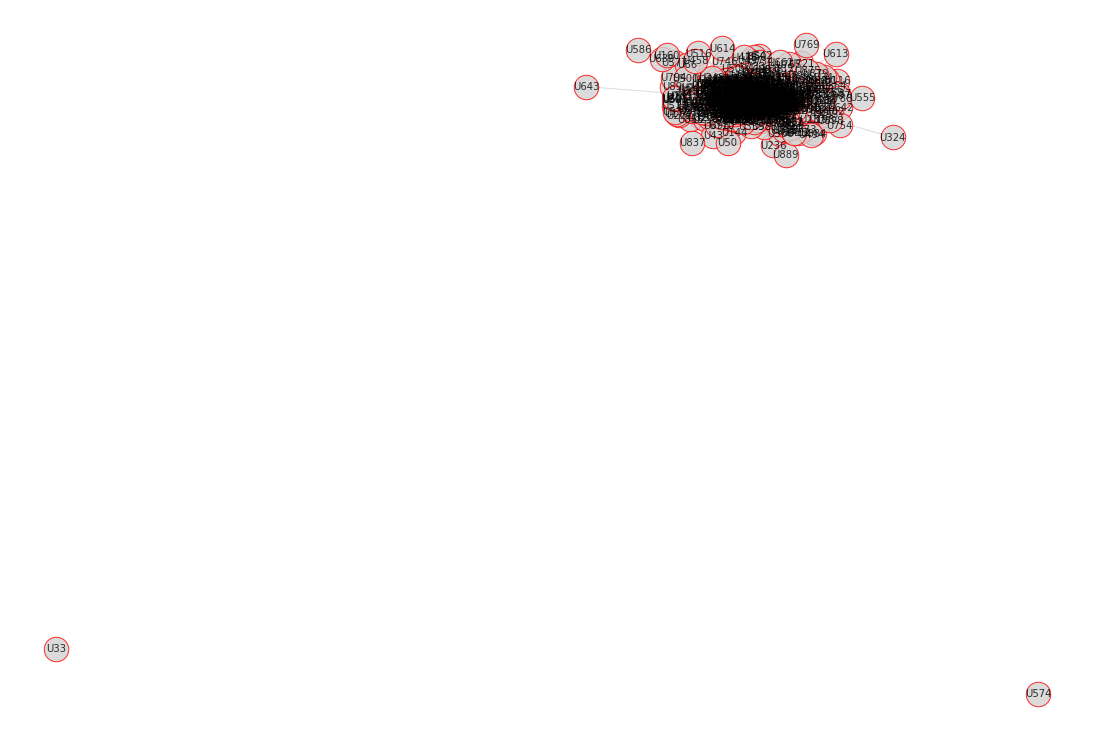

In [160]:
# User subgraph
plt.figure(figsize = (15,10))
# project graph
U = bipartite.weighted_projected_graph(B, user_nodes)

pos_U = nx.spring_layout(U)

weights_U = [edata['weight'] for f,t,edata in U.edges(data=True)]

nx.draw(U, 
        pos = pos_U, 
        with_labels=True, 
        node_color='lightgray',
        edgecolors='red',
        edge_color='lightgray',
        font_color='black', 
        node_size = 600,
        font_size=10,
        alpha=0.8)

In [161]:
# test to see if the graph is connected
print('We confirm that connected status of the graph. Graph connected status:',nx.is_connected(U))
print('The number of nodes in the projected graph:', len(U.nodes()))

We confirm that connected status of the graph. Graph connected status: False
The number of nodes in the projected graph: 899


The resulting graph projected on the User node generates a disconnected graph with a dense cluster of nodes and several single node islands.

<br>

### Measures of Centrality

In identifying the users with the highest impact on the network we used the degree, closeness, betweenness and eigenvector measures of centrality.

In [162]:
# calculate measures of centrality
deg = nx.degree(U)
c = nx.closeness_centrality(U)
b=nx.betweenness_centrality(U)
e = nx.eigenvector_centrality(U, max_iter=100) 

df = pd.DataFrame(user_nodes, columns=['User'])

df['Degree'] = df['User'].map(dict(deg))
df['Closeness'] = df['User'].map(dict(c))
df['Betweenness'] = df['User'].map(dict(b))
df['Eigenvector'] = df['User'].map(dict(e))

In [163]:
df.sort_values('Degree',ascending=False, inplace=False).round(decimals=4)

,User,Degree,Closeness,Betweenness,Eigenvector
831,U100,633,0.7714,0.0210,0.0851
727,U67,604,0.7525,0.0189,0.0817
731,U290,599,0.7494,0.0216,0.0808
387,U377,565,0.7280,0.0097,0.0808
385,U164,563,0.7274,0.0155,0.0788
...,...,...,...,...,...
631,U324,1,0.3710,0.0000,0.0002
17,U586,1,0.3733,0.0000,0.0002
790,U643,1,0.3734,0.0000,0.0002
446,U574,0,0.0000,0.0000,0.0000


<br>

Results

* Users with high centrality measures include U100, U67, U290, U377 and U164
* Users with low centrality measures include U643, U324, U586, U574, and U33	

<br>

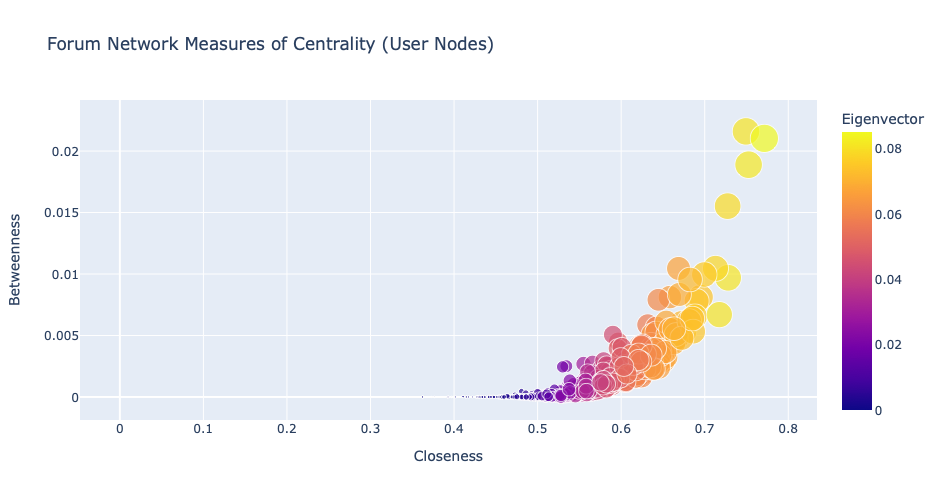

In [164]:
fig = px.scatter(df, x="Closeness", y="Betweenness", size="Degree", color="Eigenvector", 
                    hover_name="User", width=800, height=500, title="Forum Network Measures of Centrality (User Nodes)")
fig.show()

The scatter plot highlights the relationship between the 4 measures of centrality used for this analysis. There are several User nodes that are critical to the network but there is also a large population with higher than average measures of centrality.  

<br>

### User Graph Reduction

The island method of graph reduction is used to identify cliques and the primary relationships between nodes. To support that analysis we implemented 2 helper functions that trim the graph edges and control the iterations of the analysis.

In [165]:
# method to trim graph by edge weights
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,**edata)
    return g2 

 
# function to find islands
def island_method(g, iterations=5):
    
    weights=[edata['weight'] for f,to,edata in g.edges(data=True)]
 
    mn=int(min(weights))
    mx=int(max(weights))

    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)] 

The graph reduction process starts with the network graph projected on the User node. We are using the default 5 iterations for the analysis.

In [166]:
# retrieve the connected graphs
S = [U.subgraph(c).copy() for c in nx.connected_components(U)][0]
islands=island_method(S)

# create dataframe for results
island_df = pd.DataFrame(columns=['threshold','nodes','islands'])

# add the results of each iteration to the dataframe
for i,r in enumerate(islands):
    island_df.loc[i] = [r[0],len(r[1]),len(list(nx.connected_components(r[1])))]
    
    
island_df  



,threshold,nodes,islands
0,1,659,1
1,7,112,1
2,13,33,3
3,19,9,1
4,25,4,1


Using the Island Method we can reduce the graph to its primary edges. By filtering the edge weights to include only the edges with more then weight of 13. Using the resulting filter weight of 13 we can generate a weighted graph that illustrates the network structure.

In [167]:
# variable for the target weight
filter_weight = 13        
filter_U = trim_edges(U,filter_weight)        
        
# add the edge attributes        
edge_labels = nx.get_edge_attributes(filter_U, 'weight')
edge_w = np.array(list(edge_labels.values())) * 0.3

# generate the weighted data
weights=[edata['weight'] for f,t,edata in filter_U.edges(data=True)]

# calculate the degree
userDegree = nx.degree(filter_U) 

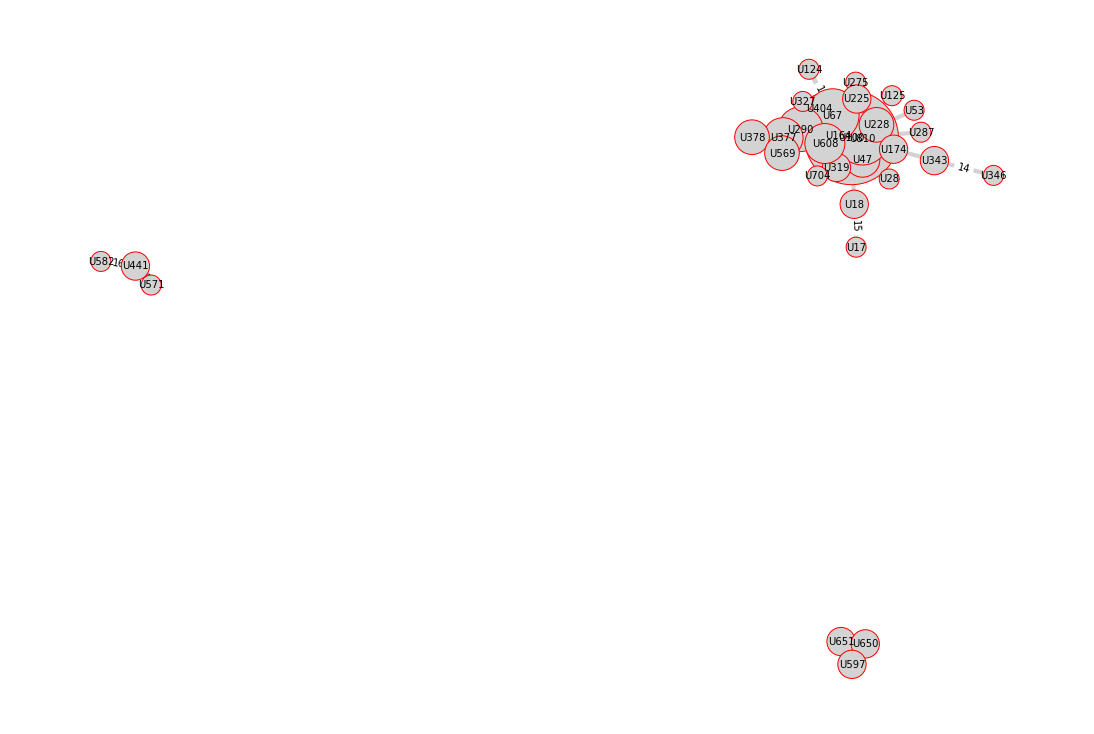

In [168]:
plt.figure(figsize = (15,10))
pos_U = nx.spring_layout(filter_U)


# plot the resulting filtered graph
nx.draw(filter_U, 
        pos=pos_U, 
        with_labels=True, 
        node_size = [v * 400 for v in dict(userDegree).values()], 
        node_color='lightgray', 
        edgecolors='red',
        font_color='black', 
        font_size=10,
        edge_cmap=mpl.cm.Greys, 
        width=edge_w, 
        edge_color='lightgray',
        edge_vmin=0, edge_vmax=20)

dump = nx.draw_networkx_edge_labels(filter_U, pos=pos_U,edge_labels=edge_labels)

In [169]:
print('Number of User Nodes:', len(filter_U.nodes()))
print('Large Clique Size:',nx.algorithms.approximation.clique.large_clique_size(filter_U))

Number of User Nodes: 33
Large Clique Size: 5


Interestingly enough there the reduced network graph illustrates 3 clusters of user nodes. Although the cluster with U100 and some of the other critical nodes the max clique size is only 5.

<br>

### Sub Graph Ego Network
We also wanted to explore the Ego Networks in Forum Network. Focusing the sub-graph on the user node U892. We selected this node due to its relatively low measures of centrality to the network. With structure of the Forum network nodes with higher degrees of connectivity do not add much insight into the graph because they are so widely connected. With a radius of 1 the number of nodes in the network is relatively small at 12 and the clustering coefficient is 1.0. This is a relatively small reach but the proportion of friends that are friends with each other is high. This suggests a high degree of trust in the close network.



In [170]:
EN = nx.ego_graph(U,'U892', radius=1)
print('The number of nodes in the network:', len(EN))
print('The average clustering for the ego network:', round(nx.average_clustering(EN),4))

The number of nodes in the network: 12
The average clustering for the ego network: 1.0


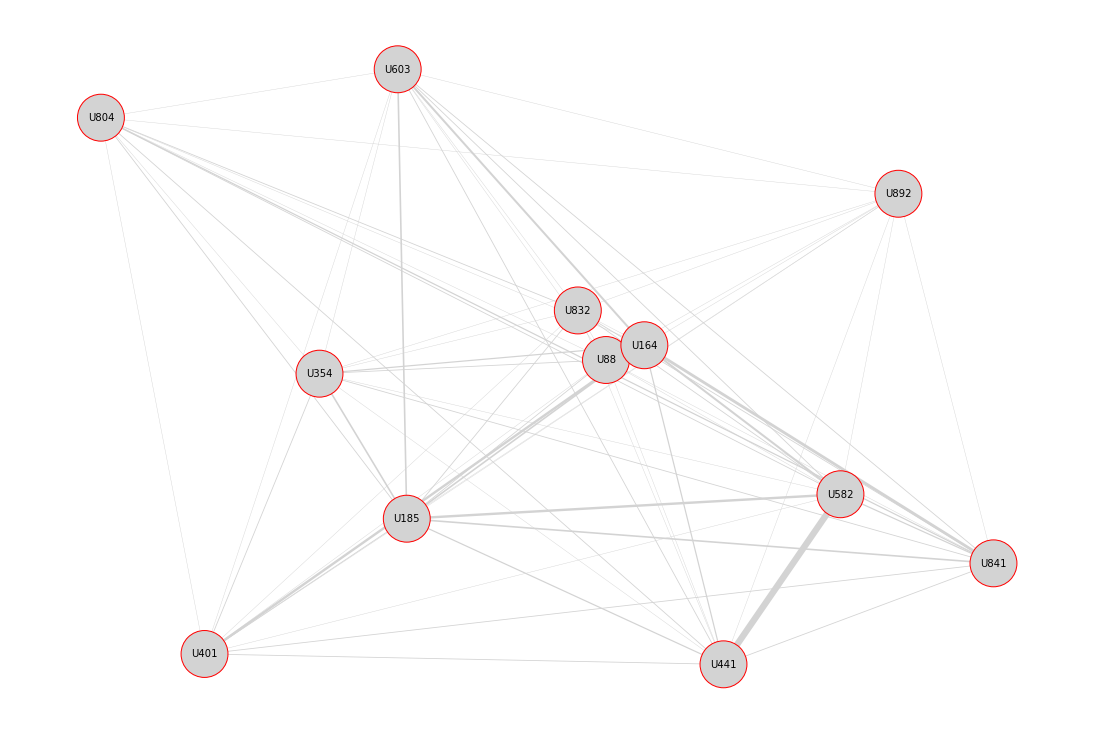

In [171]:
# config size and layout
plt.figure(figsize = (15,10))
pos = nx.random_layout(EN)

# calculate the degrees and weight for node size and edge width
userDegree = nx.degree(EN) 
edge_labels = nx.get_edge_attributes(EN, 'weight')
edge_w = np.array(list(edge_labels.values())) * 0.4

nx.draw(EN, 
        pos=pos, 
        with_labels=True, 
        node_size = [v * 200 for v in dict(userDegree).values()], 
        node_color='lightgray', 
        edgecolors='red',
        font_color='black', 
        font_size=10,
        edge_cmap=mpl.cm.Greys, 
        width=edge_w, 
        edge_color='lightgray',
        edge_vmin=0, edge_vmax=20)

plt.show()

In [172]:
EN = nx.ego_graph(U,'U892', radius=3)
print('The number of nodes in the network:', len(EN))
print('The average clustering for the ego network:', round(nx.average_clustering(EN),4))

The number of nodes in the network: 897
The average clustering for the ego network: 0.6962


Interestingly enough at a radius of 3 even a ego network for a relatively isolated node like U892 increases substantially. The clustering coefficient remains high suggesting that even at a radius of 3, the trust of the much large network is still high.

<br>

## One Mode Projection - Topics

Projection is used to analyze the centrality measures for the Forum Network. We will use degree, closeness, betweenes and eigenvectors centrality measures to assess the relative importance of each Topic node to the network

* First, we will project the graph onto the Topic node
* Calculate degree, closeness, betweenness and eigenvectors centrality for the graph
* Identify the nodes with higher centrality measures



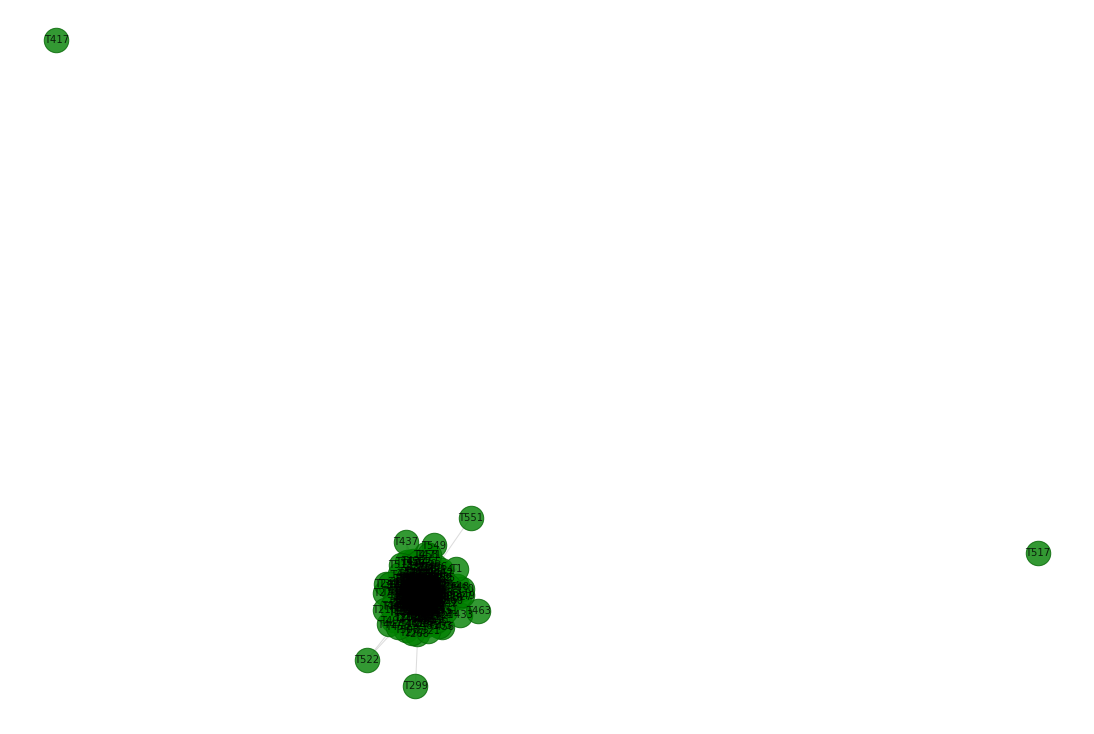

In [173]:
# topic subgraph
plt.figure(figsize = (15,10))
# project graph
T = bipartite.weighted_projected_graph(B, topic_nodes)

pos_T = nx.spring_layout(T)
weights_T = [edata['weight'] for f,t,edata in U.edges(data=True)]

nx.draw(T, pos = pos_T, 
        with_labels=True, 
        node_color='green',
        node_size = 600,
        font_color='black', 
        edgecolors='darkgreen',
        edge_color='lightgray',
        font_size=10,
        alpha=0.8)




### Measures of Centrality

In [174]:
# calculate measures of centrality
deg = nx.degree(T)
c = nx.closeness_centrality(T)
b=nx.betweenness_centrality(T)
e = nx.eigenvector_centrality(T, max_iter=100) 

df = pd.DataFrame(topic_nodes, columns=['Topic'])

df['Degree'] = df['Topic'].map(dict(deg))
df['Closeness'] = df['Topic'].map(dict(c))
df['Betweenness'] = df['Topic'].map(dict(b))
df['Eigenvector'] = df['Topic'].map(dict(e))

In [175]:
df[df['Degree'] >= 0].sort_values('Degree',ascending=False, inplace=False).round(decimals=4)

,Topic,Degree,Closeness,Betweenness,Eigenvector
51,T13,410,0.8220,0.0196,0.0900
113,T12,403,0.8142,0.0158,0.0898
497,T82,397,0.8066,0.0180,0.0880
406,T237,394,0.8003,0.0111,0.0899
93,T208,390,0.7966,0.0112,0.0892
...,...,...,...,...,...
403,T463,2,0.3932,0.0000,0.0004
420,T299,1,0.3917,0.0000,0.0003
72,T551,1,0.3463,0.0000,0.0001
320,T417,0,0.0000,0.0000,0.0000


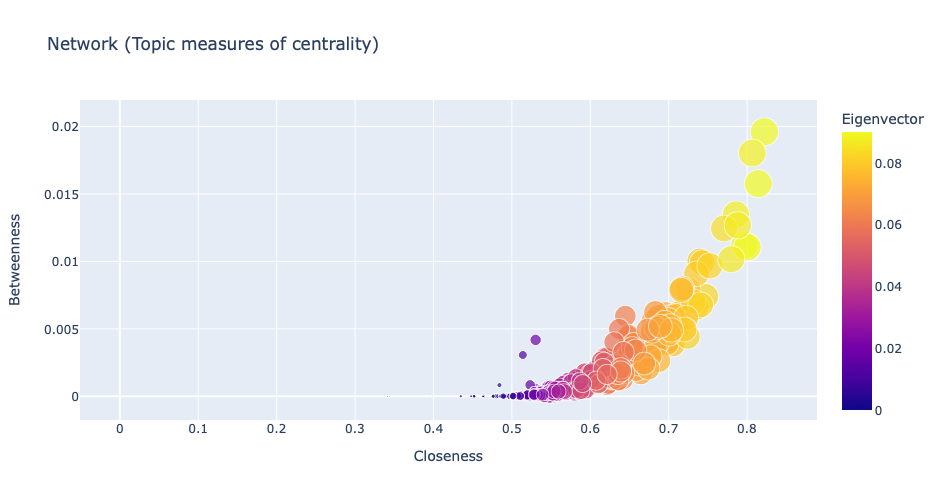

In [176]:
fig = px.scatter(df, x="Closeness", y="Betweenness", size="Degree", color="Eigenvector", 
                    hover_name="Topic", width=800, height=500, title="Network (Topic measures of centrality)")
fig.show()

### Topic Graph Reduction

In [177]:
# retrieve the connected graphs
S2 = [T.subgraph(c).copy() for c in nx.connected_components(T)][0]
islands2=island_method(S2)

# create dataframe for results
island_df2 = pd.DataFrame(columns=['threshold','nodes','islands'])

# add the results of each iteration to the dataframe
for i,r in enumerate(islands2):
    island_df2.loc[i] = [r[0],len(r[1]),len(list(nx.connected_components(r[1])))]
    
       
island_df2 

,threshold,nodes,islands
0,1,462,1
1,8,101,2
2,15,32,2
3,22,13,1
4,29,6,3
5,36,2,1


In [178]:
# variable for the target weight
filter_weight = 15       
        
filter_T = trim_edges(T,filter_weight)        
        
# add the edge attributes        
edge_labels2 = nx.get_edge_attributes(filter_T, 'weight')
edge_w = np.array(list(edge_labels2.values())) * 0.8

# generate the weighted data
weights=[edata['weight'] for f,t,edata in U.edges(data=True)]

# calculate the degree
topicDegree = nx.degree(filter_T) 

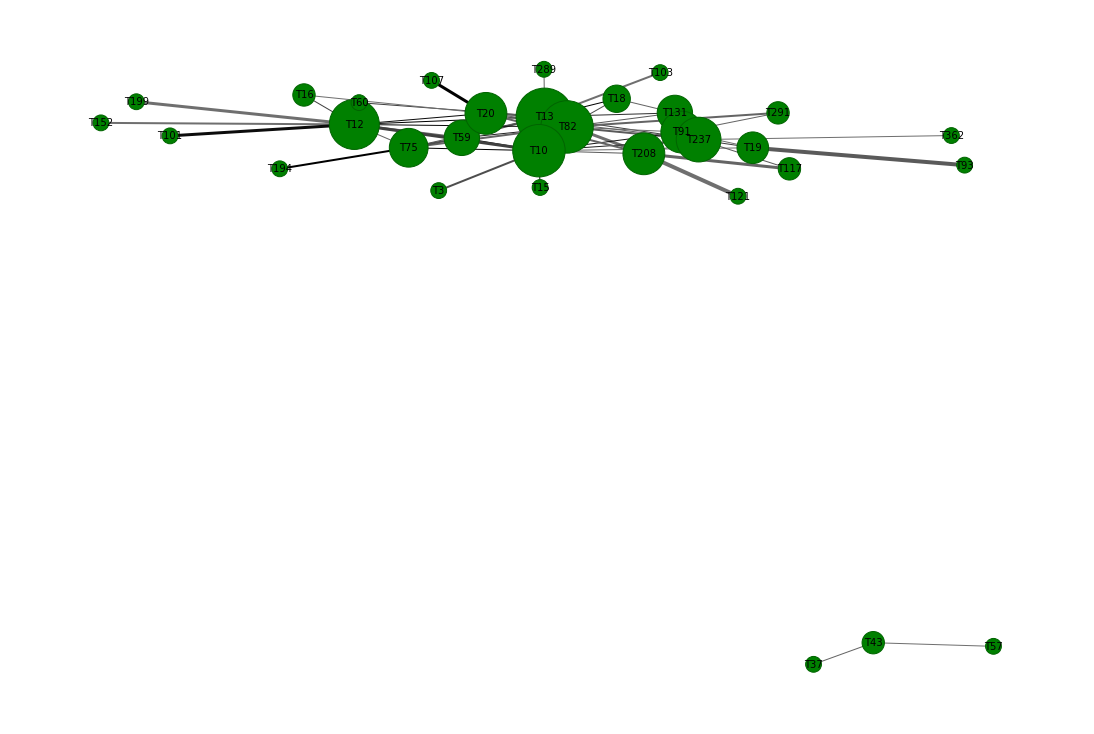

In [179]:
pos_T = nx.spring_layout(filter_T)

# plot the resulting filtered graph
plt.figure(figsize = (15,10))
nx.draw(filter_T, 
        pos=pos_T, 
        with_labels=True, 
        node_size = [v * 250 for v in dict(topicDegree).values()], 
        node_color='green', 
        edgecolors='darkgreen',
        font_color='black', 
        font_size=10,
        width=weights,
        edge_color=edge_w,
        edge_cmap=mpl.cm.Greys,
        edge_vmin=0, edge_vmax=20)


<br>


## Conclusion

The findings from Panzarasa and Opsahl concluded that:

* the Forum Network exhibits “scale-free” behavior. 
* User differ in popularity and gregariousness
* User have a tendency to forge strong ties and develop socially cohesive local environments.

The findings on the “scale-free” behavior of the system have implications for information diffusion and the robustness of the system. Although we were unable to recreate the analysis that generated these findings we can see the elements of information diffusion and robustness throughout the analysis. 

If we look at the Ego network for the least connected User. We still see interaction with x Topics and x Users at 3 degrees. The denseness of the network suggests that the network would be resilient to the removal of a single hub. 
